In [2]:
import glob
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.load_adni import load_adni2
import models.models as models
from utils.data_class import BrainDataset
import torchio as tio
from tqdm import tqdm
#from models.models import Vgg16, FujiNet1

/home/ryo32/medical-onbording/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# dataloader作成時にラベル情報を数値に変換するために使用するdict型変数
CLASS_MAP = {
    "CN": 0,
    "AD": 1,
}
# 再現性を保つために設定しておく値
SEED_VALUE = 0

In [4]:
# seed値を設定（random, Numpy, PyTorch）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = (
        False  # この行をFalseにすると再現性はとれるが、速度が落ちる
    )
    torch.backends.cudnn.deterministic = True
    return

fix_seed(0)

In [5]:
# 脳MRIの画像を読み込み（今回は"CN", "AD"のみ）
dataset = load_adni2(classes=["CN", "AD"],size="half", unique=True, mni=False, strength=["3.0"])

# datasetの枚数を表示
len(dataset)

100%|████████████████████████████████████████████████████| 571/571 [00:09<00:00, 57.11it/s]


571

In [6]:
# datasetの1枚の情報を見てみる
dataset[0]

{'pid': '098_S_4003',
 'sex': 'F',
 'age': '72.4137',
 'weight': '56.7',
 'day': '2011-03-22',
 'uid': '225425',
 'preprocessing': 'MT1; GradWarp; N3m',
 'slice_thickness': '1.2',
 'plane': 'SAGITTAL',
 'x': '1.0156',
 'y': '1.0156',
 'manufacturer': 'GE MEDICAL SYSTEMS',
 'model': 'DISCOVERY MR750',
 'strength': '3.0',
 'class': 'CN',
 'mmse': '30.0',
 'moca': '24.0',
 'class_base': 'CN',
 'mmse_base': '30.0',
 'moca_base': '24.0',
 'path_full': '/data2/radiology_datas/clean3/ADNI2/full/rigid/225425.nii',
 'path_half': '/data2/radiology_datas/clean3/ADNI2/half/rigid/225425.nii',
 'path_full_mni': '/data2/radiology_datas/clean3/ADNI2/full/trsaa/225425.nii',
 'path_half_mni': '/data2/radiology_datas/clean3/ADNI2/half/trsaa/225425.nii',
 'voxel': memmap([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

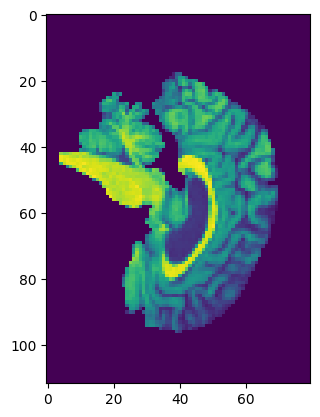

In [7]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:])

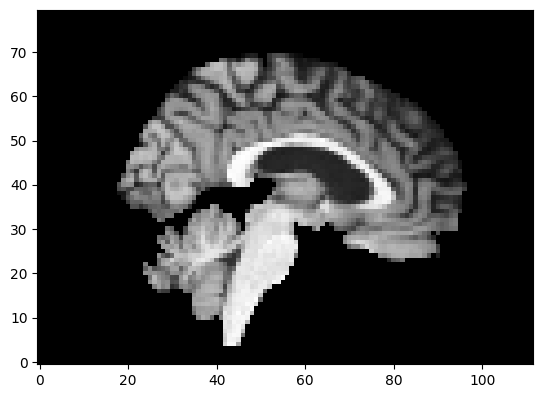

In [8]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:].T, origin="lower", cmap="gray")

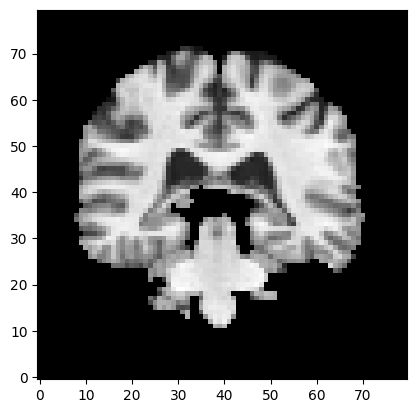

In [9]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][:,48,:].T, origin="lower", cmap="gray")

In [27]:
# datasetの」中から使用する情報をそれぞれ取ってくる
pids = []
voxels = np.zeros((len(dataset), 80, 112, 80))
labels = np.zeros(len(dataset))
for i in tqdm(range(len(dataset))):
    pids.append(dataset[i]["pid"])
    voxels[i] = dataset[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[dataset[i]["class"]]
pids = np.array(pids)

100%|███████████████████████████████████████████████████| 571/571 [00:02<00:00, 240.76it/s]


In [28]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(voxels,labels, groups=pids))[0]
train_voxels = voxels[train_idx]
val_voxels = voxels[val_idx]
train_labels = labels[train_idx]
val_labels = labels[val_idx]

len(train_voxels)

456

In [29]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [30]:
# train/val dataset を作成
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)

print("size of the training dataset = ", len(train_set))
print("size of the validation dataset = ", len(val_set))
print("training image shape = {}, training label = {}".format(train_set(0)[0].shape, train_set(0)[1]))
print("test image shape = {}, test label = {}".format(val_set(0)[0].shape, val_set(0)[1]))

size of the training dataset =  456
size of the validation dataset =  115
training image shape = (1, 80, 112, 80), training label = 0.0
test image shape = (1, 80, 112, 80), test label = 0.0


In [32]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 1, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        print(f"type={image.dtype}")
        img = np.flip(image.reshape(80, 112, 80).transpose(1,2,0)[50+i],0)
        plt.axis("off")
        plt.imshow(img,cmap="gray")
        plt.tick_params(labelsize=8)
        
    plt.show()

type=float32
type=float32
type=float32
type=float32
type=float32
type=float32


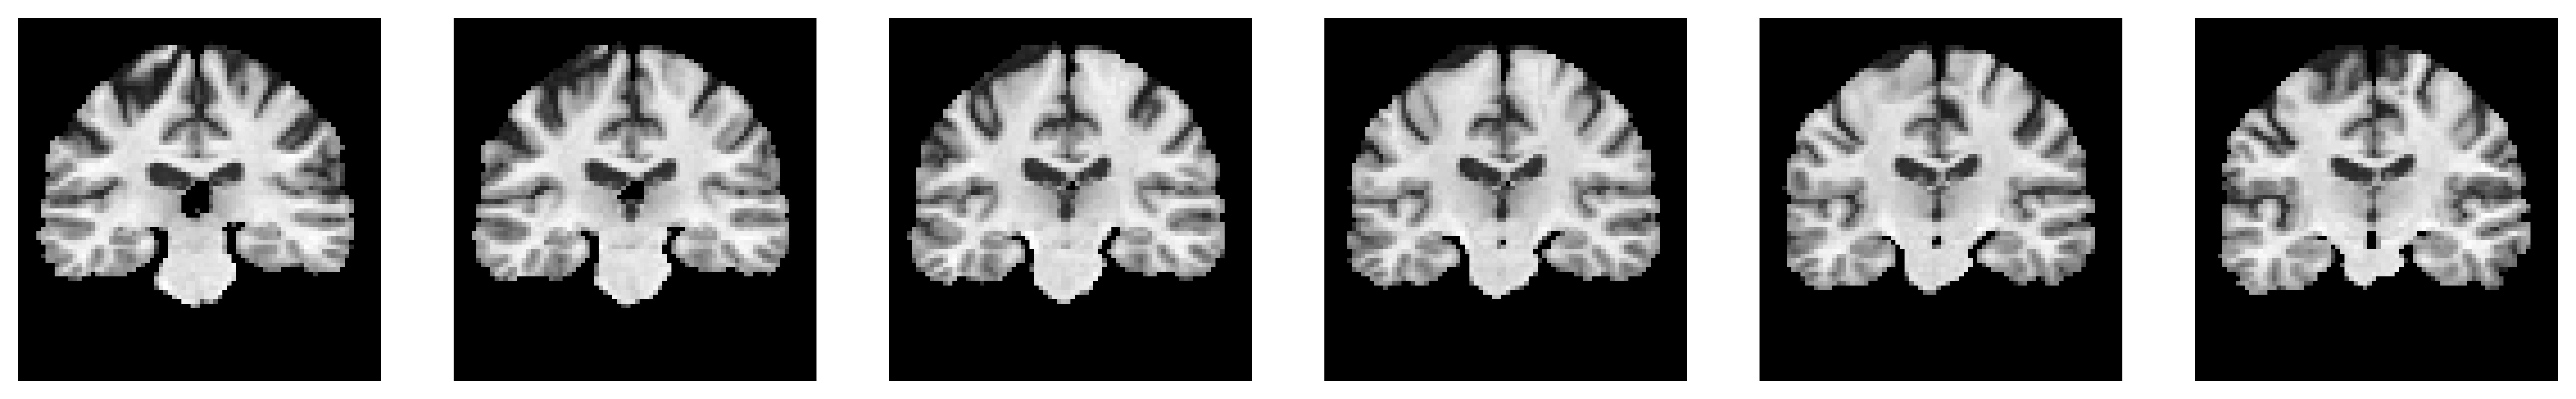

In [33]:
idx = 20
image, label = train_set(idx)

show_image(image)

mean= 0.13431239
max=1.0 min=0.0
0.0


/tmp/ipykernel_874363/589869620.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


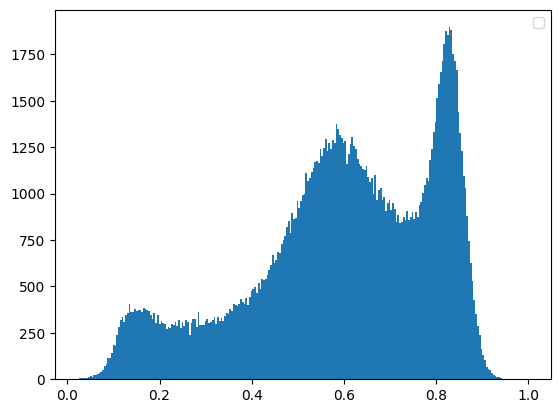

In [34]:
# 画像１枚あたりの輝度値ヒストグラム
print("mean=", image.mean())
print(f"max={image.max()} min={image.min()}")
print(label)
#imge = np.clip(image, 0, None)
show_img = image.reshape(80*112*80)
plt.hist(show_img[show_img > 0.01], bins=255)
#plt.title("Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
plt.legend()

571


(array([1.02000e+02, 2.71000e+02, 5.02000e+02, 8.44000e+02, 1.39800e+03,
        2.05400e+03, 2.87700e+03, 3.66600e+03, 4.71100e+03, 6.06900e+03,
        7.46600e+03, 9.24900e+03, 1.14480e+04, 1.41570e+04, 1.69070e+04,
        2.01130e+04, 2.43240e+04, 2.88540e+04, 3.41290e+04, 4.04420e+04,
        4.70330e+04, 5.42280e+04, 6.24160e+04, 7.05740e+04, 7.93940e+04,
        8.94480e+04, 9.89030e+04, 1.08930e+05, 1.19000e+05, 1.29422e+05,
        1.39804e+05, 1.51134e+05, 1.61218e+05, 1.71952e+05, 1.83945e+05,
        1.94296e+05, 2.06093e+05, 2.14392e+05, 2.22193e+05, 2.29637e+05,
        2.35215e+05, 2.38163e+05, 2.39691e+05, 2.39949e+05, 2.38516e+05,
        2.36014e+05, 2.32964e+05, 2.30292e+05, 2.25899e+05, 2.23759e+05,
        2.19174e+05, 2.16044e+05, 2.12820e+05, 2.10655e+05, 2.06574e+05,
        2.04247e+05, 2.00943e+05, 1.98417e+05, 1.95716e+05, 1.92573e+05,
        1.91269e+05, 1.90242e+05, 1.87203e+05, 1.87179e+05, 1.85957e+05,
        1.85255e+05, 1.85051e+05, 1.84688e+05, 1.84

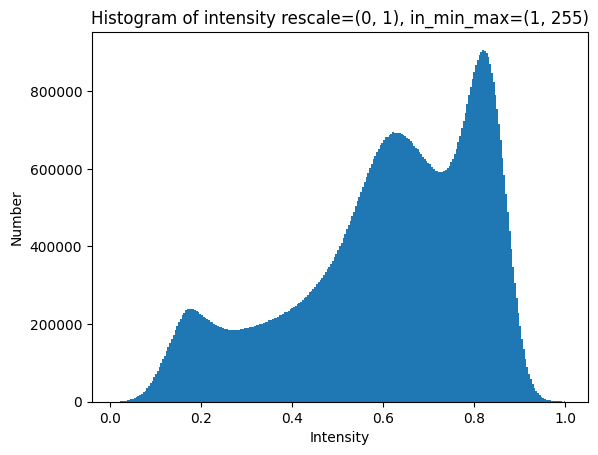

In [35]:
image_list = []
max = 0.01
for image, label in train_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)

for image, label in val_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)
print(len(image_list))

imagelist = np.concatenate(image_list)
plt.title("Histogram of intensity rescale=(0, 1), in_min_max=(1, 255)")
plt.xlabel("Intensity")
plt.ylabel("Number")
plt.hist(imagelist[imagelist > 0.01], bins=255)

In [36]:
print(max)

1.0


In [37]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

In [38]:
net = models.CNN()
print(net)

CNN(
  (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=89600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm3d1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d12): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05

In [39]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(params=net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [40]:
def train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):

    #nvidia-smiで確認してからcudaの番号を決める
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    print("Use divice = ", device)
    
    log_path = "./log/" + "output" + "_cnn/"

    for epoch in range(num_epochs):
        # train
        net.train()
        loss_avg = 0.0
        acc_avg = 0.0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(train_dataloader)
            loss_avg += loss.item() / len(train_dataloader)
        train_losses.append(loss_avg)
        train_accs.append(acc_avg)

        # evaluate
        loss_avg = 0.0 
        acc_avg = 0.0
        net.eval()
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            with torch.no_grad():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(val_dataloader)
            loss_avg += loss.item() / len(val_dataloader)

        test_losses.append(loss_avg)
        test_accs.append(acc_avg)
        print(f"EPOCH {epoch+1}  || train loss : {train_losses[epoch]:.4f}, test loss : {test_losses[epoch]:.4f} || train acc : {train_accs[epoch]:.4f} test acc : {test_accs[epoch]:.4f}")

    torch.save(net.state_dict(), log_path + "cnn_weight_1.pth")

In [41]:
num_epochs = 100

train_losses = []
test_losses = []
train_accs = []
test_accs = []

train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Use divice =  cuda:0
EPOCH 1  || train loss : 0.7554, test loss : 0.6042 || train acc : 0.6487 test acc : 0.6823
EPOCH 2  || train loss : 0.5631, test loss : 0.6956 || train acc : 0.6961 test acc : 0.7161


KeyboardInterrupt: 

課題

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def show_slices_3planes(volume,axial_index=40,coronal_index=56,sagittal_index=40):
    axial_slice=volume[axial_index,:,:]
    coronal_slice=volume[:,coronal_index,:]
    sagittal_slice=volume[:,:,sagittal_index]
    fig,axes=plt.subplots(1,3,figsize=(12,4))

    axes[0].imshpw(axial_slice.T,origin="lower",cmap="gray")
    axes[1].imshow(sagittal_slice.T,origin="lower",cmap="gray")
    axes[2].imshow(coronal_slice.T,origin="lower",cmap="gray")
    plt.show()

sample=dataset[0]["voxcel"]
show_slices_3planes(sample,axial_index=40,coronal_index=56,sagittal_index=40)




tsne umap

In [ ]:
def extract_features(net,dataloder):
    net.eval()
    all_features=[]
    all_labels=[]

    with torch.no_grad():
        for inputs,labels in dataloder:
            inputs.to(device=device)
            x=F.relu(net.fc1(net._forward_conv(inputs)))
            x=x.cpu().numpy()
            l=labels.numpy()
            all_features.append(x)
            all_labels.append(l)

    all_features=np.concatenate(all_features,axis=0)
    all_labels=np.concatenate(all_labels,axis=0)

    return all_features,all_labels






In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

features, labels_ = extract_features(net, val_dataloader)

tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)  # shape = (num_samples, 2)

plt.figure(figsize=(6,5))
sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], 
                hue=labels_, palette="Set1")
plt.title("t-SNE visualization of AD/CN")
plt.legend(labels=["CN", "AD"])  # 0:CN, 1:AD
plt.show()





In [ ]:
# pip install umap-learn してから
import umap

reducer = umap.UMAP(n_components=2, random_state=0)
features_2d_umap = reducer.fit_transform(features)

plt.figure(figsize=(6,5))
sns.scatterplot(x=features_2d_umap[:,0], y=features_2d_umap[:,1],
                hue=labels_, palette="Set1")
plt.title("UMAP visualization of AD/CN")
plt.legend(labels=["CN", "AD"])
plt.show()





In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class VAE3D(nn.Module):
    def __init__(self,latent_dim=150):
        super(VAE3D,self).__init__()
        self.latent_dim=latent_dim


        self.enc_conv1=nn.Conv3d(1,8,kernel_size=3,stride=2,padding=1)
        self.enc_conv2=nn.Conv3d(8,16,kernel_size=3,stride=2,padding=1)
        self.enc_conv3=nn.Conv3d(16,32,kernel_size=3,stride=2,padding=1)
        self.fc_mu=nn.Linear(32*10*14*10,latent_dim)
        self.fc_logvar=nn.Linear(32*10*14*10,latent_dim)



        self.fc_decode=nn.Linear(latent_dim,32*10*14*10)
        self.dec_conv1=nn.ConvTranspose3d(32,16,kernel_size=3,stride=2,padding=1, output_padding=1)
        self.dec_conv2=nn.ConvTranspose3d(16,8,kernel_size=3,stride=2,padding=1, output_padding=1)
        self.dec_conv3=nn.ConvTranspose3d(8,1,kernel_size=3,stride=2,padding=1, output_padding=1)


    

    def encoder(self,x):
        x=F.relu(self.enc_conv1(x))
        x=F.relu(self.enc_conv2(x))
        x=F.relu(self.enc_conv3(x))


        x=x.view(x.size(0),-1)

        mu=self.fc_mu(x)
        logvar=self.fc_logvar(x)


        return mu,logvar
    




    def reparametersize(self,mu,logvar):
        eps=torch.randn_like(mu)
        z=mu+torch.sqrt(torch.exp(logvar))*eps

        return z
    





    def decoder(self,z):
        x=self.fc_decode(z)
        x=x.view(-1,32,10,14,10)


        x=F.relu(self.dec_conv1(x))
        x=F.relu(self.dec_conv2(x))
        x=self.dec_conv3(x)

        x=torch.sigmoid(x)

        return x
    


    def forward(self,x):
        mu,logvar=self.encoder(x)
        z=self.reparametersize(mu,logvar)
        x_rec=self.decoder(z)



        return x_rec,mu,logvar


        




        

In [43]:
def vae_loss(x,x_rec,mu,logvar):
    recon_loss=F.mse_loss(x_rec,x,reduction="sum")

    kl_loss=-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp())


    return recon_loss+kl_loss,recon_loss,kl_loss

In [44]:
import torch
import torch.optim as optim

latent_dim=150

vae=VAE3D(latent_dim)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae.to(device)


optimizer=optim.Adam(vae.parameters(),lr=1e-4)


num_epochs=20


for epoch in range(num_epochs):
    vae.train()
    train_loss=0.0


    for images,labels in train_dataloader:
        images=images.to(device,dtype=torch.float32)
        labels=labels.to(device,dtype=torch.float32)

        optimizer.zero_grad()

        x_rec,mu,logvar=vae(images)
        loss,recon_loss,kl_loss=vae_loss(images,x_rec,mu,logvar)


        loss=loss / images.size(0)


        loss.backward()

        optimizer.step()


        train_loss+=loss.item()*images.size(0)


    avg_loss=train_loss / len(train_dataloader.dataset)

    print(f"current epoch:{epoch+1}/{num_epochs},total_loss:{avg_loss:.4f}")







current epoch:1/20,total_loss:174214.2980
current epoch:2/20,total_loss:173214.6864
current epoch:3/20,total_loss:165755.3298
current epoch:4/20,total_loss:139871.4482
current epoch:5/20,total_loss:108117.1427
current epoch:6/20,total_loss:66828.7181
current epoch:7/20,total_loss:42826.4693
current epoch:8/20,total_loss:31488.3689
current epoch:9/20,total_loss:25853.3991
current epoch:10/20,total_loss:23384.8012
current epoch:11/20,total_loss:21570.7585
current epoch:12/20,total_loss:20235.9809
current epoch:13/20,total_loss:18945.6141
current epoch:14/20,total_loss:16881.2566
current epoch:15/20,total_loss:15910.3069
current epoch:16/20,total_loss:15334.7738
current epoch:17/20,total_loss:14875.6059
current epoch:18/20,total_loss:14474.6155
current epoch:19/20,total_loss:14117.7080
current epoch:20/20,total_loss:13824.5138


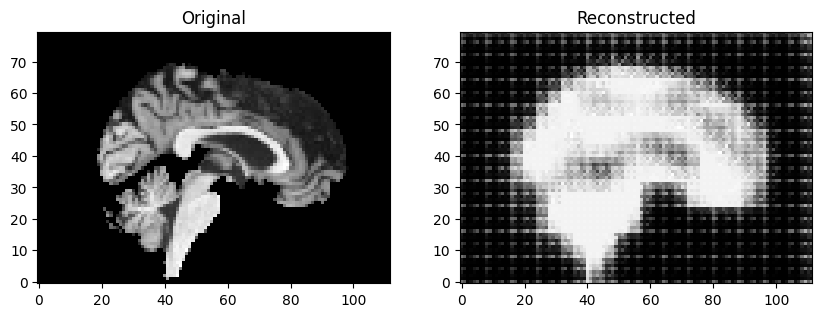

In [45]:
import matplotlib.pyplot as plt
import numpy as np

vae.eval()

with torch.no_grad():
    for images,labels in val_dataloader:
        images=images.to(device,dtype=torch.float32)
        x_rec,mu,logvar=vae(images)

        break


images=images[0].cpu().numpy()
x_rec=x_rec[0].cpu().numpy()


fig,axes=plt.subplots(1,2,figsize=(10,5))

axes[0].imshow(images[0,40,:,:].T,origin="lower",cmap="gray")
axes[0].set_title("Original")

axes[1].imshow(x_rec[0,40,:,:].T,origin="lower",cmap="gray")
axes[1].set_title("Reconstructed")
plt.show()


低次元ベクトルを取得し、分類、可視化等

In [ ]:
import numpy as np

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vae.eval()

latent_vectors=[]

true_labels=[]

with torch.no_grad():
    for images,labels in val_dataloader:
        images=images.to(device,dtype=torch.float32)


        mu,logvar=vae.encoder(images)
        z=vae.reparametersize(mu,logvar)
        latent_vectors.append(z.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

latent_vectors=np.concatenate(latent_vectors,axis=0)
true_labels=np.concatenate(true_labels,axis=0)




In [ ]:
from sklearn.cluster import KMeans



kmeans=KMeans(n_clusters=2,random_state=0)
kmeans.fit(latent_vectors)
predicted_cluster=kmeans.labels_


In [ ]:
import numpy as np

cluster_to_label={}
for cluster_id in [0,1]:
    idx=(predicted_cluster==cluster_id)
    labels_in_cluster=true_labels[idx]

    if labels_in_cluster.mean()>0.5:
        assigned_label=1
    else:
        assigned_label=0

    cluster_to_label[cluster_id]=assigned_label

predicted_labels=np.array([cluster_to_label[c] for c in predicted_cluster])



    

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, adjusted_rand_score


acc=accuracy_score(true_labels,predicted_labels)

print("K-means Accuracy",acc)



ari=adjusted_rand_score(true_labels,predicted_cluster)
print("ARI",ari)

In [ ]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2,random_state=0)
z_tsne=tsne.fit_transform(latent_vectors)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=predicted_cluster)
plt.title("t-SNE (colored by k-means clusters)")
plt.show()

plt.figure()
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=true_labels)
plt.title("t-SNE (colored by true_labels)")
plt.show()




In [ ]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
z_pca=pca.fit_transform(latent_vectors)

import matplotlib.pyplot as plt



plt.figure()
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=predicted_cluster)
plt.title("PCA of Latent Space (colored by predicted_clusters)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



plt.figure()
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels)
plt.title("PCA of Latent Space (colored by true labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()






